<a href="https://colab.research.google.com/github/Hyper-Turing/Tiny-Transformer/blob/main/tiny_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 阶段0: 环境检测与导入

In [334]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import copy
import random
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [335]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(f"GPU: {torch.cuda.get_device_name(0)}")
  print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available, using CPU")

# 设置随机种子, 保证可以复现
torch.manual_seed(42)
np.random.seed(42)

No GPU available, using CPU


In [336]:
# 核心参数
class Config:
  """ transformer 参数配置"""

  # 数据参数
  batch_size = 32 # 批大小
  src_seq_len = 10 # 输入语言(英文)的序列长度
  tgt_seq_len = 12 # 目标语言(中文)的序列长度
  src_vocab_size = 1000    # 源语言词汇表大小
  tgt_vocab_size = 1000    # 目标语言词汇表大小

  # 模型参数
  d_model = 512
  n_heads = 8
  d_ff = 2048 # 前馈网络隐藏层维度
  n_layers = 6 # encoder/decoder 层数
  dropout = 0.1 # dropout的概率

  # 特殊 token
  PAD_IDX = 0
  BOS_IDX = 1
  EOS_IDX = 2
  UNK_IDX = 4


## 明确张量形状规范
`src`: 源(英文)的token id - (batch_size, src_seq_len)

`tgt`: 目标(中文)的token id - (batch_size tgt_seq_len)

`src_mask`: enocder的self-attn padding mask - (batch, 1, 1, src_seq_len)

`tgt_mask`: decoder的self-attn padding + subsquent mask - (batch_size, 1, tgt_seq_len)

In [337]:
def make_toy_batch(cfg:Config, device=device):
  batch_size = cfg.batch_size
  src_seq_len  = cfg.src_seq_len
  tgt_seq_len  = cfg.tgt_seq_len

  src = torch.full((batch_size, src_seq_len), cfg.PAD_IDX)
  for i in range(batch_size):
    length = np.random.randint(3, src_seq_len + 1)
    src[i, 0] = cfg.BOS_IDX
    # .randint 在3~vocab_size 间随机生成整数
    src[i, 1:length-1] = torch.randint(3, cfg.src_vocab_size, (length - 2,))
    src[i, length-1] = cfg.EOS_IDX

  tgt = torch.full((batch_size, tgt_seq_len), cfg.PAD_IDX)
  for i in range(batch_size):
    length = np.random.randint(3, tgt_seq_len + 1)
    tgt[i, 0] = cfg.BOS_IDX
    tgt[i, 1:length-1] = torch.randint(3, cfg.tgt_vocab_size, (length - 2,))
    tgt[i, length-1] = cfg.EOS_IDX

  src = src.to(device)
  tgt = tgt.to(device)

  return src, tgt


src, tgt = make_toy_batch(Config)
print("src:", src.shape)
print("tgt:", tgt.shape)

print("src example:", src[0])
print("tgt example:", tgt[0])

src: torch.Size([32, 10])
tgt: torch.Size([32, 12])
src example: tensor([  1, 976, 330, 598,  68,  79, 807, 488,   2,   0])
tgt example: tensor([  1, 366, 502, 612, 379, 448, 613, 936, 213, 300, 887,   2])


# 阶段1: Embedding


## 1.1 Token Embedding

In [338]:
class Embeddings(nn.Module):
  def __init__(self, vocab_size:int, d_model:int):
    super().__init__()
    self.d_model = d_model
    self.embedding = nn.Embedding(vocab_size, d_model) # W_E: (vocab_szie, d_model)
    # X @ W_E 不合法是因为这里不是在做矩阵乘法
    # Y[b, t, :] = W_E(X[b, t, :]) 实际上时在索引

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    """
    x: (batch_size, seq_len)
    return: (batch_size, seq_len, d_model)
    """
    return self.embedding(x) * math.sqrt(self.d_model)


In [339]:
# test embedding
batch_size = 2
seq_len = 5
vocab_size = 100
d_model = 512

embedding = Embeddings(vocab_size, d_model)

x = torch.randint(0, vocab_size, (batch_size, seq_len), dtype=torch.long)
y = embedding(x)

print("input shape:", x.shape, x.dtype)
print("input value:\n", x[:, :])
print("output shape:", y.shape, y.dtype)
print("output value:\n", y[:, :2, :4])
print("mean:", y.mean().item())
print("std:", y.std().item())


input shape: torch.Size([2, 5]) torch.int64
input value:
 tensor([[96, 31, 73,  7, 23],
        [54, 22, 94, 48, 24]])
output shape: torch.Size([2, 5, 512]) torch.float32
output value:
 tensor([[[  6.9936, -26.9064,  -9.7137,   1.6625],
         [ 22.4813, -15.3386,  -1.0043, -16.9889]],

        [[ 25.8852,  50.9624,  -2.5315,  -5.6428],
         [  4.6806,   0.3475,  13.8539,  -5.0825]]], grad_fn=<SliceBackward0>)
mean: -0.35855787992477417
std: 22.52842903137207


## 1.2 Positional Encoding

In [340]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model:int, dropout:float=0.0, max_len:int=5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    # position: (max_len, 1)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

    # div_term: (1, d_model/2)
    div_term = torch.exp(
        torch.arange(0, d_model, 2, dtype=torch.float)
        * (-math.log(10000) / d_model)
    ).unsqueeze(0)


    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0) # ->(1, max_len, d_model) 方便与batch相加(广播机制)

    # 注册为buffer
    self.register_buffer("pe", pe)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x = x + self.pe[:, :x.size(1)] # x; (batch_size, seq_len, d_modle) 即上面embed的输出
    return self.dropout(x)

batch, seq_len, d_model = 2, 10, 512
x = torch.randn(batch, seq_len, d_model)
pe = PositionalEncoding(d_model)
y = pe(x)

print("y.shape:", y.shape)

y.shape: torch.Size([2, 10, 512])


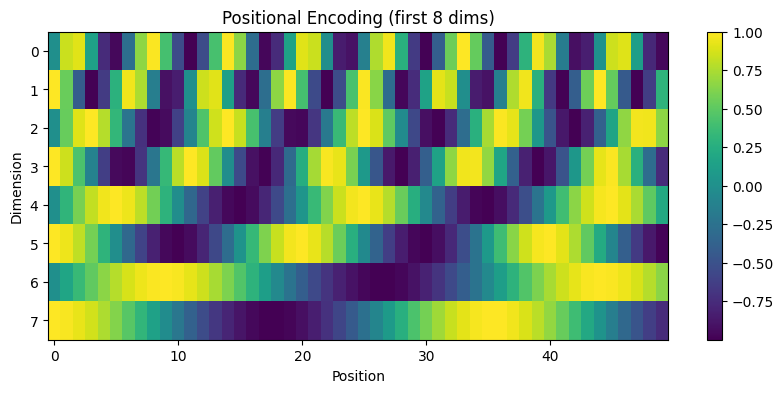

In [341]:
import matplotlib.pyplot as plt

pe = PositionalEncoding(d_model=32, dropout=0.0)
pos_encoding = pe.pe[0, :50, :8]  # [50 positions, 8 dims]

plt.figure(figsize=(10, 4))
plt.imshow(pos_encoding.T, aspect="auto", cmap="viridis")
plt.xlabel("Position")
plt.ylabel("Dimension")
plt.title("Positional Encoding (first 8 dims)")
plt.colorbar()
plt.show()


# 阶段2: Attention机制

## 1.1 Scaled Dot-Product Attention
$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$


In [342]:
def attention(query, key, value, mask=None, dropout=None):
  """
  计算缩放点积 Scaled Dot-Product Attention
  query: (batch, headi, seq_len_q, d_k)
  key:   (batch, headi, seq_len_k, d_k)
  value: (batch, headi, seq_len_k, d_v)
  mask:  (batch, 1 or headi, seq_len_q, seq_len_k) padding mask or subsequent mask
  output: (batch, h, seq_len_q, seq_len_k)
  """
  d_k = query.size(-1)

  # 1. QK^T / sqrt(kd)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)# scores: (batch, h, seq_q, seq_k)

  # 2. mask(被mask的位置为-inf)
  if mask is not None:
    mask = mask.to(torch.bool)
    scores = scores.masked_fill(~mask, -1e9)


  # 3. softmax
  attention_weights = F.softmax(scores, dim=-1)

  # 4.dropout
  if dropout is not None:
    attention_weights = dropout(attention_weights)

  # V的加权求和
  output = torch.matmul(attention_weights, value)

  return output, attention_weights


In [343]:
def visualize_attention(attn, head=0, batch=0):
    """
    attn: [batch, h, seq_q, seq_k]
    """
    plt.imshow(attn[batch, head].detach().cpu(), cmap="viridis")
    plt.colorbar()
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.title(f"Attention Head {head}")
    plt.show()


test1:  True
test2: Max attention on masked positions: 0.0
test3: output shape: torch.Size([2, 4, 6, 8])
	 attention weights shape: torch.Size([2, 4, 6, 6])


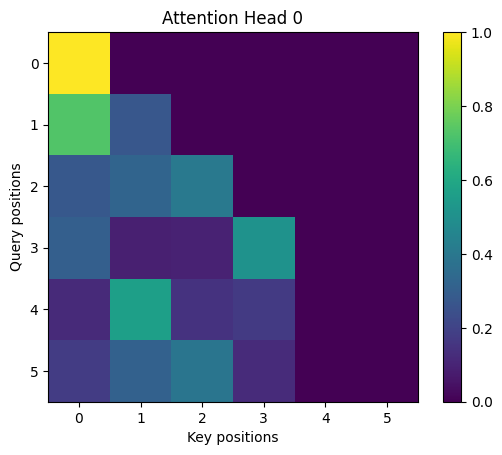

In [344]:
# 测试
def make_padding_mask(src, pad_idx=0):
    return (src != pad_idx).unsqueeze(1).unsqueeze(2)

def make_subsequent_mask(seq_len):
    return torch.tril(
        torch.ones((seq_len, seq_len))
    ).bool().unsqueeze(0).unsqueeze(1)

torch.manual_seed(42)

batch, heads, seq_len, d_k, pad_idx = 2, 4, 6, 8, 0
# 假设这是token序列, 包括padding
x = torch.tensor([
    [1, 2, 3, 4, 0, 0],
    [5, 6, 7, 0, 0, 0]
  ])

#QKV
query = torch.randn(batch, heads, seq_len, d_k)
key  = torch.randn(batch, heads, seq_len, d_k)
value = torch.randn(batch, heads, seq_len, d_k)

# test 1
# softmax行和=1
outputs, attn_weight = attention(query, key, value, mask=None)
attn_sum = attn_weight.sum(dim=-1)
print("test1: ", torch.allclose(attn_sum, torch.ones_like(attn_sum), atol=1e-6))

# test 2
# 被mask的位置=0
padding_mask = make_padding_mask(x, pad_idx) # (b,1,1,s)
subsequent_mask  = make_subsequent_mask(seq_len)  # (1,1,s,s)

mask = padding_mask & subsequent_mask # (b,1,s,s)

output_masked, attn_masked = attention(
    query, key, value, mask=mask
)
masked_positions = ~mask
masked_values = attn_masked.masked_select(masked_positions)

print("test2: Max attention on masked positions:",
      masked_values.max().item())

# test 3
# 检查输出的shpe
print("test3: output shape:", output_masked.shape)
print("\t attention weights shape:", attn_masked.shape)

# test 4
visualize_attention(attn_masked, head=0, batch=0)

## 2.2 Multi-Head Attention

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.


In [345]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout=0.0):
    super().__init__()
    assert d_model % num_heads == 0

    self.d_model = d_model
    self.h = num_heads
    self.d_k = d_model // num_heads

    # 四个Linear networks, 每个的大小是(512, 8*64)的
    self.W_q = nn.Linear(d_model, d_model)
    self.W_k = nn.Linear(d_model, d_model)
    self.W_v = nn.Linear(d_model, d_model)
    self.W_o = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout)

  def forward(self, query, key, value, mask=None):
    batch_size, seq_len_q, _ = query.size()
    seq_len_k = key.size(1)

    # 我们假设d_k == d_v
    assert key.size(1) == value.size(1)

    # 1. 线性映射
    # x;(batch seq_len, d_model) @ W:(d_model, d_model) -> (batch seq_len, d_model)
    Q = self.W_q(query)
    K = self.W_k(key)
    V = self.W_v(value)

    #2. 分头
    Q = Q.view(batch_size, seq_len_q, self.h, self.d_k).transpose(1, 2)
    K = K.view(batch_size, seq_len_k, self.h, self.d_k).transpose(1, 2)
    V = V.view(batch_size, seq_len_k, self.h, self.d_k).transpose(1, 2) # [batch, h, seq_len, d_k]

    # 3. 计算注意力得分
    out, attn = attention(Q, K, V, mask=mask, dropout=self.dropout)

    # 4. 合并
    out = out.transpose(1, 2).contiguous()
    out = out.view(batch_size, seq_len_q, -1) # [batch, seq_len, d_model]

    # 5. 投影
    out = self.W_o(out)

    return out, attn

In [346]:
# test 1
batch, seq, d_model = 2, 5, 64
x = torch.randn(batch, seq, d_model)

mha_1 = MultiHeadAttention(d_model=d_model, num_heads=1)
mha_8 = MultiHeadAttention(d_model=d_model, num_heads=8)

out1, attn1 = mha_1(x, x, x)
out8, attn8 = mha_8(x, x, x)

print("single head output:", out1.shape)
print("multi head output :", out8.shape)

# test 2
print("attn shape (single head):", attn1.shape)
print("attn shape (multi head) :", attn8.shape)

# test 3
x = torch.randn(2, 5, 64, requires_grad=True)

mha = MultiHeadAttention(d_model=64, num_heads=8)

out, attn = mha(x, x, x)

loss = out.mean()
loss.backward()

print("W_q grad exists:", mha.W_q.weight.grad is not None)
print("W_o grad exists:", mha.W_o.weight.grad is not None)
print("input grad exists:", x.grad is not None)



single head output: torch.Size([2, 5, 64])
multi head output : torch.Size([2, 5, 64])
attn shape (single head): torch.Size([2, 1, 5, 5])
attn shape (multi head) : torch.Size([2, 8, 5, 5])
W_q grad exists: True
W_o grad exists: True
input grad exists: True


## 2.3 mask

In [347]:
def make_src_mask(src, pad_idx=0):
  """
  encoder padding mask
  src: (batch, src_seq_len)
  """
  batch_size, seq_len = src.size()
  mask = (src != pad_idx).unsqueeze(1).unsqueeze(2) # mask: (batch, 1, 1, src_seq_len)
  mask = mask.expand(batch_size, 1, seq_len, seq_len).contiguous()
  return mask

def make_tgt_mask(tgt, pad_idx=0):
  """
  decoder padding + subsequent mask
  tgt: (batch, tgt_seq_len)
  """
  batch_size, seq_len = tgt.size()

  # padding mask
  padding_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2) # (batch, 1, 1, tgt_seq_len)
  # subsequent mask
  subsequent_mask = torch.tril(
      torch.ones((seq_len, seq_len), device=tgt.device)
  ).bool().unsqueeze(0).unsqueeze(0) # (1, 1, tgt_seq_len, tgt_seq_len)

  mask = (padding_mask & subsequent_mask).bool() # (batch, 1, seq_len ,seq_len)

  return mask

def make_cross_attn_mask(src, tgt, pad_idx=0):
  """
  Decoder cross-attention mask
  src: (batch, src_seq_len)
  tgt: (batch, tgt_seq_len)
  return: (batch, 1, tgt_seq_len, src_seq_len)
  """
  batch_size = src.size(0)
  src_len = src.size(1)
  tgt_len = tgt.size(1)

  # Src padding mask: (batch, 1, 1, src_len)
  src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)

  # 扩展到 (batch, 1, tgt_len, src_len)
  mask = src_mask.expand(batch_size, 1, tgt_len, src_len)
  return mask

# 阶段3: Position-wise FFN

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$


In [348]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model, d_ff=2048, dropout=0.0):
    super().__init__()
    self.linear1 = nn.Linear(d_model, d_ff)
    self.linear2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(p=dropout)

  """
  x = W1x + b1
  x = ReLu(x)
  x = dropout(x)
  x = W2x + b2
  """
  def forward(self, x):
    return self.linear2(
        self.dropout(
            F.relu(self.linear1(x))
        )
    )

In [349]:
# test
batch, seq_len, d_model = 2, 5, 512
ffn = PositionwiseFeedForward(d_model)

x = torch.randn(batch, seq_len, d_model)
y = ffn(x)

print("input shape:", x.shape)
print("output shape:", y.shape)

input shape: torch.Size([2, 5, 512])
output shape: torch.Size([2, 5, 512])


# 阶段4: Encoder

## 4.1 Encoder Layer

In [350]:
class LayerNorm(nn.Module):
  def __init__(self, features, eps=1e-6): # features == d_model
    super().__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [351]:
class SublayerConnection(nn.Module):
  # 层归一化 + 残差连接 Add&Norm
  def __init__(self, size, dropout):
    super().__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    # sublayer: self-attn or ffn
    return x + self.dropout(sublayer(self.norm(x)))

In [352]:
class EncoderLayer(nn.Module):
  def __init__(self, size, self_attn, feed_forward, dropout=0.0):
    super().__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward

    self.sublayer = nn.ModuleList([
        SublayerConnection(size, dropout),
        SublayerConnection(size, dropout)
    ])

    self.size = size

  def forward(self, x, mask):
    # 1. x' = x + self-attention(LN(x))
    x = self.sublayer[0](
        x,
        lambda x: self.self_attn(x, x, x, mask)[0]
    )
    # 2. x' + FFN(LN(x))
    return self.sublayer[1](x, self.feed_forward)


In [353]:
# padding test
batch, seq_len, d_model = 2, 10, 512
x = torch.randn(batch, seq_len, d_model)
src = torch.tensor([
    [1,2,3,4,5,6,7,8,0,0],
    [1,2,3,4,5,6,7,8,0,0]
])
src_mask = make_src_mask(src)

encoder_layer = EncoderLayer(
    size=d_model,
    self_attn=MultiHeadAttention(d_model, 8),
    feed_forward=PositionwiseFeedForward(d_model, 2048)
)

y = encoder_layer(x, src_mask)
print(y.shape == x.shape)

True


In [354]:
batch, seq_len, d_model = 1, 10, 512

src = torch.tensor([[1,2,3,4,5,6,7,8,0,0]])
src_mask = make_src_mask(src)

x = torch.randn(batch, seq_len, d_model)

self_attn = MultiHeadAttention(d_model, 8)
out, attn = self_attn(x, x, x, src_mask)

# attn: (batch, heads, seq_len_q, seq_len_k)
# 检查key维度上pad_idx位置
pad_attn = attn[0, 0, :, 8:]
print(torch.allclose(pad_attn, torch.zeros_like(pad_attn)))

True


## 4.2 Encoder Stack

In [355]:
class Encoder(nn.Module):
  def __init__(self, layer, N):
    super().__init__()
    self.layers = nn.ModuleList([
      copy.deepcopy(layer) for _ in range(N)
    ])
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

In [356]:
# 梯度测试
encoder_layer = EncoderLayer(
    size=512,
    self_attn=MultiHeadAttention(512, 8),
    feed_forward=PositionwiseFeedForward(512, 2048)
)

encoder = Encoder(encoder_layer, N=6)
x = x = torch.randn(2, 10, 512, requires_grad=True)
mask = torch.ones(2, 1, 1, 10)

out = encoder(x, mask)
head = nn.Linear(512, 1)

loss = head(out).mean()
loss.backward()

# 第一层
first_layer = encoder.layers[0]
print(first_layer.self_attn.W_q.weight.grad.abs().mean())
# 最后一层
last_layer = encoder.layers[-1]
print(last_layer.self_attn.W_q.weight.grad.abs().mean())

tensor(0.0003)
tensor(0.0002)


# 阶段5: Decoder

## 5.1 Decoder Layer

In [357]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout=0.0):
      super().__init__()
      self.self_attn = self_attn
      self.src_attn = src_attn
      self.feed_forward = feed_forward

      self.sublayer = nn.ModuleList([
          SublayerConnection(size, dropout), # self-attn
          SublayerConnection(size, dropout), # cross-attn
          SublayerConnection(size, dropout), # ffn
      ])

      self.size = size

    def forward(self, x, memory, src_mask, tgt_mask):
      m = memory
      # 1. 第一个子层连接：自注意力机制 x = x + self-attention(LN(x))
      x = self.sublayer[0](
          x,
          lambda x: self.self_attn(x, x, x, tgt_mask)[0]
        )
      # 2. 第二个子层连接：交叉注意力机制 x = x + cross-attention(LN(x))
      x = self.sublayer[1](
          x,
          lambda x: self.src_attn(x, m, m, src_mask)[0]
        )
      # 3. 第三个子层连接：前馈神经网络 x + FFN(LN(x))
      return self.sublayer[2](x, self.feed_forward)

In [358]:
batch, tgt_len, src_len, d_model = 2, 6, 10, 512

x = torch.randn(batch, tgt_len, d_model)
memory = torch.randn(batch, src_len, d_model)

tgt = torch.tensor([
    [1,2,3,4,0,0],
    [1,2,3,4,5,0]
])
tgt_mask = make_tgt_mask(tgt)

decoder_layer = DecoderLayer(
    size=d_model,
    self_attn=MultiHeadAttention(d_model, 8),
    src_attn=MultiHeadAttention(d_model, 8),
    feed_forward=PositionwiseFeedForward(d_model, 2048)
)

y = decoder_layer(x, memory, None, tgt_mask)
print(y.shape == x.shape)

True


## 2.2 Decoder Stack

In [360]:
class Decoder(nn.Module):
  def __init__(self, layer, N):
    super().__init__()
    self.layers = nn.ModuleList([
        copy.deepcopy(layer) for _ in range(N)
    ])
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

In [361]:
# shape test
torch.manual_seed(0)
batch, tgt_len, src_len, d_model = 2, 6, 10, 32

x = torch.randn(batch, tgt_len, d_model)
memory = torch.randn(batch, src_len, d_model)

tgt = torch.tensor([
    [1, 2, 3, 4, 0, 0],
    [1, 2, 3, 4, 5, 0]
])
tgt_mask = make_tgt_mask(tgt)

decoder = Decoder(
    DecoderLayer(
        size=d_model,
        self_attn=MultiHeadAttention(d_model, 4),
        src_attn=MultiHeadAttention(d_model, 4),
        feed_forward=PositionwiseFeedForward(d_model, 64),
    ),
    N=4
)
y = decoder(x, memory, src_mask=None, tgt_mask=tgt_mask)

print(y.shape == x.shape)

# test 2
head = nn.Linear(d_model, 1)
loss = head(y).mean()
loss.backward()

# 第一层
first_layer = decoder.layers[0]
print(first_layer.self_attn.W_q.weight.grad.abs().mean())
# 最后一层
last_layer = decoder.layers[-1]
print(last_layer.self_attn.W_q.weight.grad.abs().mean())

True
tensor(0.0013)
tensor(0.0008)


# 阶段6: Generator


In [362]:
# decoder的hidden state转为概率分布
class Generator(nn.Module):
  def __init__(self, d_model, vocab_size):
    super().__init__()
    self.proj = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    # return F.log_softmax(self.proj(x), dim=-1)
    return self.proj(x) # logits

# 阶段7: 组装Transformer

In [363]:
class Transformer(nn.Module):
  def __init__(self,
         src_vocab_size,
         tgt_vocab_size,
         d_model,
         d_ff,
         N,
         h,
         dropout):
    super().__init__()

    self.src_embed = nn.Sequential(
        Embeddings(src_vocab_size, d_model),
        PositionalEncoding(d_model, dropout)
    )

    self.tgt_embed = nn.Sequential(
        Embeddings(tgt_vocab_size, d_model),
        PositionalEncoding(d_model, dropout)
    )

    self.encoder = Encoder(
        EncoderLayer(d_model,
               MultiHeadAttention(d_model, h),
               PositionwiseFeedForward(d_model, d_ff),
               dropout),
        N
    )

    self.decoder = Decoder(
        DecoderLayer(d_model,
               MultiHeadAttention(d_model, h),
               MultiHeadAttention(d_model, h),
               PositionwiseFeedForward(d_model, d_ff),
               dropout),
        N
    )

    self.generator = Generator(d_model, tgt_vocab_size)

  def forward(self, src, tgt, src_mask, tgt_mask, cross_attn_mask):
    enc_output = self.encoder(self.src_embed(src), src_mask)
    dec_output = self.decoder(
        self.tgt_embed(tgt),
        enc_output,
        cross_attn_mask,
        tgt_mask
      )

    return self.generator(dec_output)

In [364]:
# check
model = Transformer(
    src_vocab_size=100,
    tgt_vocab_size=120,
    d_model=64,
    d_ff=128,
    N=2,
    h=4,
    dropout=0.1
)

batch_size, src_len, tgt_len = 2, 10, 9
src = torch.randint(3, 100, (batch_size, src_len))  # 避免特殊token
tgt = torch.randint(3, 120, (batch_size, tgt_len))

src_mask = make_src_mask(src, pad_idx=0)
tgt_mask = make_tgt_mask(tgt, pad_idx=0)
cross_maks = make_cross_attn_mask(src, tgt, pad_idx=0)

out = model(src, tgt, src_mask, tgt_mask, cross_maks)

# 验证shape
expected_shape = (batch_size, tgt_len, 120)  # [batch, tgt_seq_len, vocab_size]
print(out.shape == expected_shape)

True


# 阶段8: Label Smoothing

In [365]:
class LabelSmoothing(nn.Module):
  def __init__(self, vocab_size, pad_idx, smoothing=0.1):
    super().__init__()
    self.criterion = nn.KLDivLoss(reduction='sum')
    self.pad_idx = pad_idx
    self.smoothing = smoothing
    self.vocab_size = vocab_size

  # x: (token_num = batch*seq_len, vocab_size)
  # target: (token_num)
  def forward(self, x, target):
    x = torch.nn.functional.log_softmax(x, dim=-1)
    with torch.no_grad():
      true_dist = torch.zeros_like(x) # true_dist: (token_nums, vocab_size)
      true_dist.fill_(self.smoothing / (self.vocab_size - 2)) # ε / (V - 2)
      # .scatter(dim=1, index, value) == 在vocab_size维度上, 按照index的位置填入value
      # 即在第i个时间步, 正确的词的概率为1-ε, 其他词为ε/(V - 2)
      true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
      true_dist[:, self.pad_idx] = 0.0 # 清空词表中表示<pad>的列

      mask = target != self.pad_idx # 找出哪些token表示<pad>
      true_dist = true_dist * mask.unsqueeze(1) # 把对targer是pad的一行清零

    loss = self.criterion(x, true_dist) # KL(true_dist || model_dist)
    return loss / mask.sum()


# 阶段9 : 优化器

In [366]:
# Warmup: 线性增长
# lr = d_model^(-0.5) * min(step^(-0.5), step * warmup_steps^(-1.5))
def make_noam_lambda(d_model, warmup, factor=1.0):
  def rate(step):
    step = max(step, 1)
    return factor * (
        d_model ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )
  return rate

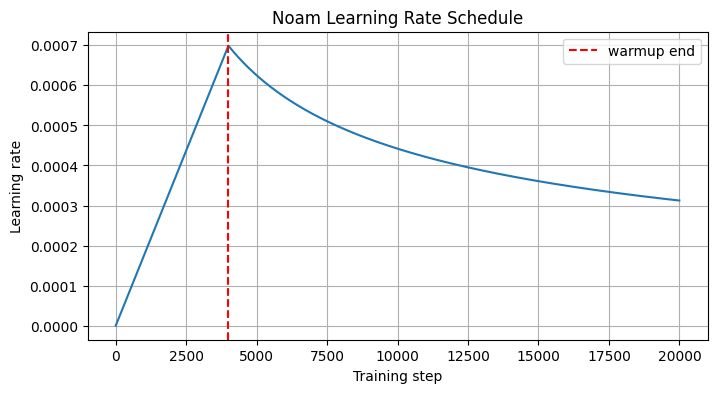

In [367]:
# learning rate warmup可视化
model = torch.nn.Linear(10, 10)

d_model = 512
warmup_steps = 4000

optimizer = Adam(model.parameters(), lr=1.0)
scheduler = LambdaLR(
    optimizer,
    lr_lambda=make_noam_lambda(d_model, warmup_steps)
)

lrs = []

for step in range(1, 20000):
    optimizer.step()
    scheduler.step()     # 更新 lr
    lrs.append(optimizer.param_groups[0]["lr"])

plt.figure(figsize=(8, 4))
plt.plot(lrs)
plt.axvline(warmup_steps, color='r', linestyle='--', label='warmup end')
plt.xlabel("Training step")
plt.ylabel("Learning rate")
plt.title("Noam Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


# 阶段10: Train
简单训练循环, 跑通一个epoch
为了验证模型 真的学会了，我们用一个极其容易过拟合的任务：

复制任务（Copy Task）
输出 = 输入右移一位

这是 NLP 里经典 sanity check。

In [368]:
class SimpleCopyDataset(Dataset):
  def __init__(self, num_samples=100, seq_len=10, vocab_size=20):
    # PAD=0, BOS=1, EOS=2, UNK=4
    self.src = torch.randint(5, vocab_size, (num_samples, seq_len))

    # 目标序列 = [BOS=1] + src + [EOS=2]
    self.tgt = torch.cat([
        torch.ones(num_samples, 1, dtype=torch.long),   # BOS=1
        self.src,                                         # 原始序列
        torch.ones(num_samples, 1, dtype=torch.long) * 2 # EOS=2
    ], dim=1)  # shape: (num_samples, seq_len+2)

  def __len__(self):
    return len(self.src)

  def __getitem__(self, index):
    return self.src[index], self.tgt[index]

In [371]:
def greedy_decode(
    model,
    src,
    max_len,
):
    model.eval()
    device = src.device
    batch = src.size(0)

    pad_idx=0,
    bos_idx=1,
    eos_idx=2

    tgt = torch.full((batch, 1), bos_idx, dtype=torch.long, device=device)

    for _ in range(max_len):
        src_mask = make_src_mask(src, pad_idx)
        tgt_mask = make_tgt_mask(tgt, pad_idx)
        cross_mask = make_cross_attn_mask(src, tgt, pad_idx)

        logits = model(src, tgt, src_mask, tgt_mask, cross_mask)
        next_token = logits[:, -1].argmax(dim=-1, keepdim=True)

        tgt = torch.cat([tgt, next_token], dim=1)

        if (next_token == eos_idx).all():
            break

    return tgt


In [369]:
dataset = SimpleCopyDataset(
    num_samples=3000,
    seq_len=10,
    vocab_size=30
)

loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

In [370]:
model = Transformer(
    src_vocab_size=30,
    tgt_vocab_size=30,
    d_model=128,
    d_ff=512,
    h=4,
    N=2,
    dropout=0.0
)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1.0,
    betas=(0.9, 0.98),
    eps=1e-9
)

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=make_noam_lambda(
        d_model=128,
        warmup=200
    )
)

criterion = LabelSmoothing(
    vocab_size=30,
    pad_idx=0,
    smoothing=0.0
)

In [372]:
model.train()
losses = []

accumulation_steps = 4 # 梯度累计
optimizer.zero_grad()

for epoch in range(20):
    for step, (src, tgt) in enumerate(loader):

        tgt_input = tgt[:, :-1]   # BOS + tokens
        tgt_y = tgt[:, 1:]    # tokens + EOS

        src_mask = make_src_mask(src, pad_idx=0)
        tgt_mask = make_tgt_mask(tgt_input, pad_idx=0)
        cross_mask = make_cross_attn_mask(src, tgt_input, pad_idx=0)

        logits = model(src, tgt_input, src_mask, tgt_mask, cross_mask)

        loss = criterion(
            logits.view(-1, logits.size(-1)),
            tgt_y.reshape(-1)
        ) / accumulation_steps

        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        losses.append(loss.item() * accumulation_steps)

        if step % 10 == 0:
            with torch.no_grad():
                pred = logits.argmax(dim=-1)
                valid = (tgt_y != 0) & (tgt_y != 2)
                acc = ((pred == tgt_y) & valid).float().sum() / valid.sum()

            print(
                f"Epoch {epoch} step {step:03d} | "
                f"loss {loss.item() * accumulation_steps:.4f} | "
                f"acc {acc.item():.3f} | "
                f"lr {optimizer.param_groups[0]['lr']:.6f}"
            )

    # model.eval()
    # src_dbg, tgt_dbg = dataset[0]
    # src_dbg = src_dbg.unsqueeze(0)

    # with torch.no_grad():
    #     out = greedy_decode(
    #         model,
    #         src_dbg,
    #         max_len=12,
    #         pad_idx=0,
    #         bos_idx=1,
    #         eos_idx=2
    #     )

    # print("SANITY src :", src_dbg[0].tolist())
    # print("SANITY out :", out[0, 1:-1].tolist())
    # model.train()


Epoch 0 step 000 | loss 3.5836 | acc 0.019 | lr 0.000031
Epoch 0 step 010 | loss 3.5893 | acc 0.028 | lr 0.000063
Epoch 0 step 020 | loss 3.5711 | acc 0.022 | lr 0.000156
Epoch 0 step 030 | loss 3.5499 | acc 0.034 | lr 0.000219
Epoch 0 step 040 | loss 3.5467 | acc 0.028 | lr 0.000313
Epoch 0 step 050 | loss 3.5460 | acc 0.031 | lr 0.000375
Epoch 0 step 060 | loss 3.5642 | acc 0.022 | lr 0.000469
Epoch 0 step 070 | loss 3.4534 | acc 0.044 | lr 0.000531
Epoch 0 step 080 | loss 3.4745 | acc 0.019 | lr 0.000625
Epoch 0 step 090 | loss 3.4308 | acc 0.025 | lr 0.000688
Epoch 1 step 000 | loss 3.3746 | acc 0.006 | lr 0.000719
Epoch 1 step 010 | loss 3.3670 | acc 0.022 | lr 0.000781
Epoch 1 step 020 | loss 3.2953 | acc 0.019 | lr 0.000875
Epoch 1 step 030 | loss 3.2823 | acc 0.009 | lr 0.000938
Epoch 1 step 040 | loss 3.2168 | acc 0.016 | lr 0.001031
Epoch 1 step 050 | loss 3.2187 | acc 0.000 | lr 0.001094
Epoch 1 step 060 | loss 3.1692 | acc 0.013 | lr 0.001187
Epoch 1 step 070 | loss 3.1788 

Input : [15, 20, 20, 5, 20, 18, 15, 25, 10, 15]
Output: [15, 20, 20, 5, 20, 18, 15, 25, 15, 10]


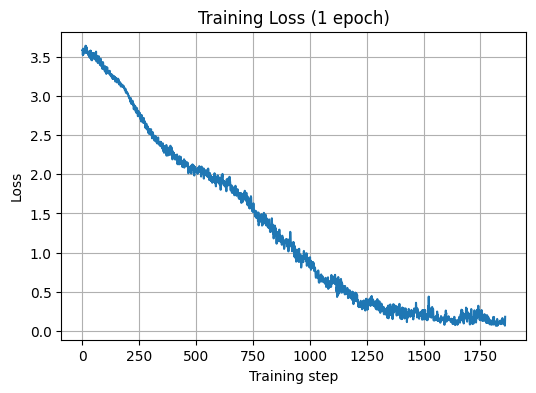

In [374]:
model.eval()
test_src = torch.randint(5, 30, (1, 10))

with torch.no_grad():
    out = greedy_decode(
        model,
        test_src,
        max_len=12
    )

print("Input :", test_src[0].tolist())
print("Output:", out[0, 1:-1].tolist())

plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss (1 epoch)")
plt.grid(True)
plt.show()
